In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

Angrist (1990) aim at studying the effects of military services during the Vietnam War on long-term earnings of the veterans. The author implements the Wald estimator by instrumenting military service with a draft-eligibility dummy that was determined by a lottery over birthdays. In particular, from 1970 to 1972, random sequence numbers were randomly assigned to each birth date in cohorts of 19 years old men. Men with lottery number below a given eligibility threshold number were eligible for the draft, while men above the threshold could not be drafted.

In [2]:
# Here I load the data:
data = pd.read_stata('../data/problemset2.dta')

In [3]:
# And here I declare the variables
D = data.veteran
y = data.earnings
Z = data.eligible
# Adding constants to both treatment and instrument:
D = sm.add_constant(D.ravel())
Z = sm.add_constant(Z.ravel())


# OLS vs. IV

The dataset problemset2.dta contains information on cohorts of 1950, 1951 and 1952. Run a regression of ”future earnings” (i.e. earnings in years 1981-1984) on ”veteran status” dummy. Discuss the potential bias of the estimated impact of veteran status on future earnings and its sign. Run an IV estimation instrumenting ”veteran status” with ”eligibility” dummy, as done in class (using the ivregress command). How does the point estimate of the variable ”veteran status” compare to the one obtained before?

Here we are considering the two stages:

$Y_i = \beta D_i + U_i$,<br>
$D_i = \pi Z_i + V_i$,

where:

$Y_i$: long-term earnings (years 1981-1984),<br>
$D_i$: military service dummy (veteran status),<br>
$Y_i$: draft dummy (instrument for military service)

## OLS:

I use the following to compute the OLS estimator $\beta_{OLS} = (D^{T}D)^{-1}D^{T}Y % = \frac{\sum_{i=1}^{N}D_iY_i}{\sum_{i=1}^{N}D_i^2}$

In [4]:
results = sm.OLS(y,D).fit()
print(f'intercept: {results.params[0]}')
print(f'coefficient: {results.params[1]}')
#print(f'standard error: {results.bse[1]}')

intercept: 11087.813550054656
coefficient: 169.11351548493417


where the first term reflects the constant (i.e. the average future earnings for individuals with veteran status equal to 0) and the second term indicates the measured effect of $D$ on the outcome. It is straight-forward to see that this estimator is biased in case $D$ is endogenous, that is $𝔼(D^{T}u)=𝔼(D^{T}(Y−Dβ))≠0$:

$\beta_{OLS} = (D^{T}D)^{-1}D^{T}Y$


The bias of the OLS regression is therefore:<br>
$
𝔼[\hat{\beta} - \beta_0] = 𝔼[(D^{T}D)^{-1}D^{T}Y - \beta_0] \\
\;\;\;\;\;\;\;\;\;\;\;\;\;= 𝔼[(D^{T}D)^{-1}D^{T}(D \beta_0 + u) - \beta_0] \\
\;\;\;\;\;\;\;\;\;\;\;\;\;= \beta_0 + 𝔼[(D^{T}D)^{-1}D^{T}u] - \beta_0 \\ 
\;\;\;\;\;\;\;\;\;\;\;\;\;= 𝔼[𝔼[(D^{T}D)^{-1}D^{T}u | D]] \\ 
\;\;\;\;\;\;\;\;\;\;\;\;\;= 𝔼[(D^{T}D)^{-1}D^{T}𝔼[u|D]] \\
\;\;\;\;\;\;\;\;\;\;\;\;\;\not= 0 \;\;(if\;endogeneity)
$

Hence, if $𝔼[u|D] \not= 0$ (endogeneity) $\Rightarrow$ $𝔼[\hat{\beta} - \beta_0] \not= 0 $

The concern of endogeneity in this naive OLS framework can be rationalized in the following way: Although the drafting process can be thought of as a randomized control trial, not everyone that got drafted ended up serving in the military. And to quote Angrist "comparing civilian earnings by veteran status may be biased by the fact that certain types of men are more likely to serve in the armed forces than others" So there are certainly variables, such as courage or disagreeableness, lack of health issues which have an impact on both likelihood to enlist and future income. If the total sum of all these endogenous variables impacts the likelihood to enlist in the same direction as it impacts future earnings, the negative effect of veteran status on future earnings will likely be underestimated and is here in fact even positive.

## IV:

In [5]:
def iv_regression(X, y, instrument):
    term_1 = np.linalg.inv(np.dot(instrument.transpose(),X))
    term_2 = np.dot(instrument.transpose(),y)

    return np.dot(term_1, term_2)

In [6]:
print(f'intercept: {iv_regression(D, y, Z)[0]}')
print(f'coefficient: {iv_regression(D, y, Z)[1]}')


intercept: 11890.962308239861
coefficient: -4417.356563412002


As expected, since we control for endogeneity with the IV estimator we get a much more negative (this time actually negative) coefficient.

# Why does the bias disappear?

Explain why this bias disappears if ”veteran status” dummy is instrumented with the ”eligibility” dummy described above. State which are the necessary identifying assumptions and interpret them in this context.

The bias disappears under the assumption that the instrument is valid – that is $(Y_1i,Y_0i)\indep Z_i|D_i$ and relevant – that is $Z_i \not \indep D_i|X_i$. This implies a structural causal model which can be illustrated through a causal graph:

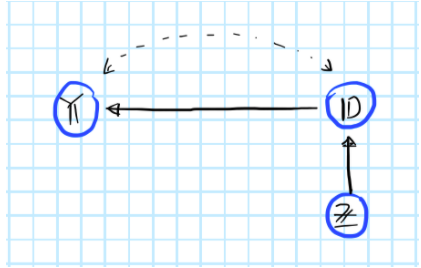

$\beta_{IV} = (Z^{T}D)^{-1}Z^{T}Y$


The bias of the IV regression is therefore:<br>
$
𝔼[\hat{\beta} - \beta_0] = 𝔼[(Z^{T}D)^{-1}Z^{T}Y - \beta_0] \\
\;\;\;\;\;\;\;\;\;\;\;\;\;= 𝔼[(Z^{T}D)^{-1}Z^{T}(D \beta_0 + u) - \beta_0] \\
\;\;\;\;\;\;\;\;\;\;\;\;\;= \beta_0 + 𝔼[(Z^{T}D)^{-1}Z^{T}u] - \beta_0 \\ 
\;\;\;\;\;\;\;\;\;\;\;\;\;= 𝔼[𝔼[(Z^{T}D)^{-1}Z^{T}u | D, Z]] \\ 
\;\;\;\;\;\;\;\;\;\;\;\;\;= 𝔼[(Z^{T}D)^{-1}Z^{T}𝔼[u|D, Z]] \\
\;\;\;\;\;\;\;\;\;\;\;\;\;= 0
$

Hence, if $𝔼[u|D, Z] = 0$ (exogeneity of the instrument) $\Rightarrow$ $𝔼[\hat{\beta} - \beta_0] = 0 $

$\Rightarrow$ If the instrument is valid, the bias term disappears.

# Structural, reduced form and first stage equations

Describe which are the structural, reduced form and first stage equations in this setup. Analytically show that, together, they provide the ’formula’ for the IV estimator, i.e. <br>

$β_D = \hat{ρ}_Z / \hat{α}_Z, (1)$ <br>

where $β_D$, $ρ_Z$ and $α_Z$ are, respectively, the coefficients that multiply $Z_i$ on the structural, reduced form and first stage equations, respectively. Use the problemset2.dta data to estimate the necessary equations to show that, indeed, estimating $β_D$ as in (1) provides the same (or very close) estimates from the IV regression you made on exercise 1.

First stage equation is the regression of treatment $D_i$ on the instrument $Z_i$: <br>
$ D_i = \alpha_0 + \alpha_ZZ_i + \epsilon_i^{ZD}$, <br>
with the first stage estimator: <br>
$\hat{α}_Z = (Z^{T}Z)^{-1} Z^{T}D
$

The structural equation is the regression of outcome $Y_i$ on the treatment $D_i$ (The naive regression we would run if we didn't know we need an instrument due to endogeneity): <br>
$Y_i = \beta_0 + \beta_D D_i + \epsilon_i^D$, <br>
with the structural estimator: <br>
$\hat{\beta}_D = (D^{T}D)^{-1} D^{T}Y
$

The reduced form equation is the regression of outcome $Y_i$ on the instrument $Z_i$: <br>
$Y_i = \rho_0 + \rho_Z Z_i + \epsilon_i^{ZY}$, <br>
with the structural estimator: <br>
$\hat{\rho}_D = (Z^{T}Z)^{-1} Z^{T}Y
$

$
\begin{align}
Y_i & = \beta_0 + \beta_DD_i + \epsilon_i^D \\
    & = \beta_0 + \beta_D(\alpha_0 + \alpha_ZZ_i + \epsilon_i^{ZD}) + \epsilon_i^D \\
    & = (\beta_0 + \beta_D\alpha_0) + \beta_D\alpha_ZZ_i + (\beta_D\epsilon_i^{ZD} + \epsilon_i^D) \\
    & = \rho_0 + \rho_ZZ_i + \epsilon_i^{ZY}
\end{align}
$

By equating coefficients we get

$ \rho_0 = \beta_0 + \beta_D\alpha_0, \\
\rho_Z = \beta_D\alpha_Z, \\
\epsilon_i^{ZY} =  \beta_D\alpha_ZZ_i + (\beta_D\epsilon_i^{ZD} + \epsilon_i^D) $

Therefore, 

$ \beta_D = \frac{\rho_Z}{\alpha_Z} $

In [48]:
# First stage:
alpha = sm.OLS([n[1] for n in D],Z).fit()
alpha_0 = alpha.params[0]
alpha_Z = alpha.params[1]

# Reduced form:
rho = sm.OLS(y,Z).fit()
rho_0 = rho.params[0]
rho_z = rho.params[1]

In [49]:
# reconstructing the IV intercept:
beta_0 = rho.params[0] - beta_D * alpha.params[0]
# reconstructing the IV coefficient:
beta_D = rho.params[1] / alpha.params[1]

print(f'intercept: {beta_0}')
print(f'coefficient: {beta_D}')

intercept: 11890.962308239838
coefficient: -4417.3565634118


And as we can see, the results are exactly the same as they were in the original IV regression.

# Wald estimand


Using: <br>
$ \rho_Z = \frac{Cov(Z_i, Y_i)}{Var(Z_i)} $, <br>
$ \alpha_Z = \frac{Cov(Z_i, D_i)}{Var(Z_i)} $ <br>

we get: 

$ \beta_D = \frac{\rho_Z}{\alpha_Z} = \frac{\frac{Cov(Z_i, Y_i)}{Var(Z_i)}}{\frac{Cov(Z_i, Y_i)}{Var(Z_i)}} = \frac{Cov(Z_i, Y_i)}{Cov(Z_i, D_i)}$

Numerator:
$
\begin{align}
Cov(Z_i, Y_i) & = 𝔼[Z_i Y_i] - 𝔼[Z_i]𝔼[Y_i] \\
              & = 𝔼[𝔼[Y_i|Z_i]] - P[Z_i = 1] 𝔼[𝔼[Y_i|Z_i]] \\
              & = 𝔼[Y_i|Z_i=1]\times 1 \times P(Z_i=1) + 𝔼[Y_i|Z_i=0]\times 0 \times P(Z_i=0) - P(Z_i=1)\{ 𝔼 [Y_i|Z_i =1]P(Z_i=1) + 𝔼[Y_i|Z_i=0](1- P(Z_i=1))\} \\
              & = 𝔼[Y_i|Z_i=1] P(Z_i=1) + 0 - P(Z_i=1)\{ 𝔼[Y_i|Z_i =1]P(Z_i=1) + 𝔼[Y_i|Z_i=0](1- P(Z_i=1))\} \\
              & = 𝔼[Y_i|Z_i=1]P(Z_i=1)(1 - P(Z_i=1)) - P(Z_i=1)𝔼[Y_i|Z_i=0](1- P(Z_i=1)) \\
              &= P(Z_i=1)(1-P(Z_i=1)) \{𝔼[Y_i|Z_i = 1] - 𝔼[Y_i|Z_I = 0] \}
\end{align}
$
Denominator:
$
\begin{align}
Cov(Z_i, D_i) & = 𝔼[Z_i D_i] - 𝔼[Z_i]𝔼[D_i] \\
              & = 𝔼[𝔼[D_i|Z_i]] - P[Z_i = 1] 𝔼[𝔼[D_i|Z_i]] \\
              & = 𝔼[D_i|Z_i=1]\times 1 \times P(Z_i=1) + 𝔼[D_i|Z_i=0]\times 0 \times P(Z_i=0) - P(Z_i=1)\{ 𝔼 [D_i|Z_i =1]P(Z_i=1) + 𝔼[D_i|Z_i=0](1- P(Z_i=1))\} \\
              & = 𝔼[D_i|Z_i=1] P(Z_i=1) + 0 - P(Z_i=1)\{ 𝔼[D_i|Z_i =1]P(Z_i=1) + 𝔼[D_i|Z_i=0](1- P(Z_i=1))\} \\
              & = 𝔼[D_i|Z_i=1]P(Z_i=1)(1 - P(Z_i=1)) - P(Z_i=1)𝔼[D_i|Z_i=0](1- P(Z_i=1)) \\
              &= P(Z_i=1)(1-P(Z_i=1)) \{𝔼[D_i|Z_i = 1] - 𝔼[D_i|Z_I = 0] \}
\end{align}
$

Putting it all together, we get: <br>
$ \beta_D = \frac{\rho_Z}{\alpha_Z} = \frac{\frac{Cov(Z_i, Y_i)}{Var(Z_i)}}{\frac{Cov(Z_i, Y_i)}{Var(Z_i)}} = \frac{Cov(Z_i, Y_i)}{Cov(Z_i, D_i)} = \frac{P(Z_i=1)(1-P(Z_i=1)) \{𝔼[Y_i|Z_i = 1] - 𝔼[Y_i|Z_I = 0] \}}{P(Z_i=1)(1-P(Z_i=1)) \{𝔼[D_i|Z_i = 1] - 𝔼[D_i|Z_I = 0]} = \frac{𝔼[([Y_i|Z_i = 1] - 𝔼[([Y_i|Z_I = 0]}{𝔼[([D_i|Z_i=1]-𝔼[([D_i|Z_i=0]}
$








Testing the theory with the data is fairly easy:

In [50]:
# Reconstructing the causal impact with the WALD estimator
numerator = data[data.eligible==1].earnings.mean() - data[data.eligible==0].earnings.mean()
denominator = data[data.eligible==1].veteran.mean() - data[data.eligible==0].veteran.mean()
wald = numerator/denominator
print(wald)
print('Comparison:')
print(f"Wald estimator:{round(wald,2)}, beta_D:{round(beta_D,2)}, iv_estimator:{round(iv_regression(D, y, Z)[1],2)}")

-4418.378880064565
Comparison:
Wald estimator:-4418.38, beta_D:-4417.36, iv_estimator:-4417.36


As we can see, the IV estimation, its derivation with structural/reduced form/first stage equations and the Wald estimator, as expected, all yield the same result.

# Exclusion restriction

The exclusion restriction, namely that $Z$ affects the outcome variable $Y$ only through $D$, is violated. With respect to the example at hand, the new setup suggests that the eligibility dummy has an effect on future earnings even in the absence of veteran status. In other words, future earnings are expected to depend on the outcome of the Draft Lottery independent of whether or not men actually ended up going to war. This is not entirely implausible. Consider for example the effect of the lottery outcome on always-defiers. Suppose an always-defier is draft-eligible, but in order to avoid being drafted they choose to enrol in college, which they had not done if it were not for the lottery outcome. Then under the assumption that college education increase lifetime earnings, the lottery outcome has a positive effect on lifetime earnings, independent of veteran status.



We are considering the following models: <br>
$Y_i = \beta_0 + \beta_D D_i + \beta_Z Z_i + U_i$, where $\beta_Z \not = 0 $ <br>
$D_i = \alpha_0 + \alpha_Z Z_i + V_i$,


The bias of the IV regression is therefore:<br>

$
\begin{align}
𝔼[\hat{\beta} - \beta_D] & = 𝔼[(Z^{T}D)^{-1}Z^{T}Y - \beta_D] \\
                         & = 𝔼[(Z^{T}D)^{-1}Z^{T}(\beta_0 + D \beta_D + Z\beta_Z + u) - \beta_D] \\
                         & = \beta_D + 𝔼[(Z^{T}D)^{-1}Z^{T}(\beta_0 + Z\beta_Z + u)] - \beta_D \\ 
                         & = 𝔼[(Z^{T}D)^{-1}Z^{T}𝔼[u|Z,D] + 𝔼[(Z^{T}D)^{-1}Z^{T}(\beta_0 + Z\beta_Z])\;\; where\; the \;first\; term = 0, as\; 𝔼[u|Z,D] = 0 \\ 
                         & = 𝔼[(Z^{T}D)^{-1}Z^{T}(\beta_0 + Z\beta_Z]) \\ 
                         & = 𝔼[(Z^{T}\alpha_0 + \alpha_Z Z + v)^{-1}Z^{T}(\beta_0 + Z\beta_Z]) \\ 
                         & = 𝔼[(Z^{T}(\alpha_0 + \alpha_Z Z) + Z^{T}v)^{-1}Z^{T}(\beta_0 + Z\beta_Z]) \\ 
                         & = 𝔼[(Z^{T}(\alpha_0 + \alpha_Z Z) + Z^{T}𝔼[v|Z])^{-1}Z^{T}(\beta_0 + Z\beta_Z]) \\ 
and\;because\; 𝔼[v|Z] = 0: \\
                         & = 𝔼[(Z^{T}(\alpha_0 + \alpha_Z Z))^{-1}Z^{T}(\beta_0 + Z\beta_Z]) \\ 
                         & = 𝔼[(\alpha_0 + \alpha_Z Z)^{-1}(Z^{T})^{-1}Z^{T}(\beta_0 + Z\beta_Z]) \\ 
                         & = 𝔼[(\alpha_0 + \alpha_Z Z)^{-1}(\beta_0 + Z\beta_Z]) \\ 
                         & \not= 0, as\; \beta_Z \not = 0 
\end{align}
$

$𝔼[v|Z] = 0$, as we are assuming the first stage regression to be exogenous


Neglecting the constants, the size of the bias depends on the ratio between the direct effect of the instrument on outcome ($\beta_Z$) and the first stage effect ($\alpha_Z$): <br>

$\Rightarrow$ positively on $\beta_Z$ <br>
$\Rightarrow$ negatively on $\alpha_Z$

The bias is strong if the direct impact of the instrument is huge compared to the impact through treatment
By the same token we have a weak bias if most of the instruments impact on outcome goes through treatment.

# LATE

The additional assumption needed in order to interpret the Wald estimator as the effect of veteran status on those whose treatment status can be changed by the instrument is __monotonicity__. Monotonicity means that there are __no defiers__, i.e.:
- Men who ended up serving in the military without being drafted would also have served, had they been drafted
- Men who did not serve in the military despite having been drafted would not have served either, had they not been drafted

Under these assumptions our IV estimator can be called the local average treatment effect for compliers, i.e.:
- those that served in the military only because they have been drafted (they would not have served, had they not been drafted)
- those that did not serve in the military only because they have not been drafted (they would have served if they had been drafted)

(In other words, the estimated causal impact is that of the compliers, not of always- nor never-takers.)


# Weak instrument

a)
Since $α_Z$ measures the effect of the instrument $Z$ on $D$, $α_Z→0$ implies that the instrument is weak and hence the IV estimator is subject to weak instrument bias. The exclusion restriction is not satisfied as it requires relevance of the instrument. In other words, for there to be an exclusively through $D$ running effect, there must be an effect in the first place and with $α_Z→0$ there is none.

b) Given:

$Y_i = \beta D_i + U_i$,<br>
$D_i = \alpha_Z Z_i + V_i$,<br>
The bias of the IV estimator can be derived as follows:

$
\begin{align}
\hat{\beta}_{IV} & = \frac{\sum_{i=1}^{N}Z_i Y_i}{\sum_{i=1}^{N}Z_i D_i} \\
& = \frac{\sum_{i=1}^{N}Z_i (\beta D_i + U_i)}{\sum_{i=1}^{N}Z_i D_i} \\
& = \frac{\sum_{i=1}^{N}Z_i (\beta \alpha_Z Z_i + \beta V_i + U_i)}{\sum_{i=1}^{N}Z_i (\alpha_Z Z_i + V_i)} \\
& = \frac{\beta \sum_{i=1}^{N}Z_i (\alpha_Z Z_i + V_i) + \sum_{i=1}^{N} Z_i U_i)}{\sum_{i=1}^{N}Z_i (\alpha_Z Z_i + V_i)} \\
& = \beta + \frac{\sum_{i=1}^{N}(Z_i U_i)}{\sum_{i=1}^{N} Z_i (\alpha_Z Z_i + V_i)}  
\end{align}
$

where the true model is restated with constants equal to zero for simplification.
Then if $σ_{UV}≠0$ we can decompose it into its predictable component and noise:

$U_i = 𝔼[U_i|V_i] + ε_i = σ_{UV}/σ_V^2 V_i+ε_i$

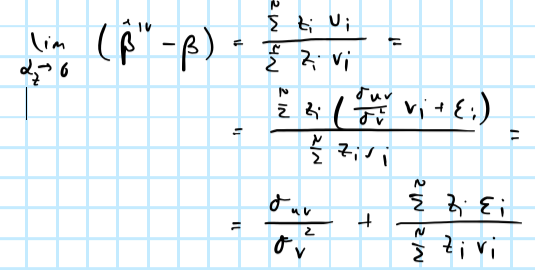

Given $𝔼(ε_i|Z_i,V_i) = 0$ the IV estimator suffers from the same bias as the OLS estimator.

$%\beta_{OLS} = \frac{\sum_{i=1}^{N}D_iY_i}{\sum_{i=1}^{N}D_i^2} = \beta + \frac{\sum_{i=1}^{N}(\pi Z_i + V_i) Y_i}{\sum_{i=1}^{N}(\pi Z_i + V_i)^2}  $

